In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import torch
from dqn_arch.model import *
import torchvision
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
import copy
from itertools import product
import pickle
device = 'cpu'

In [2]:
from ga_model import *

In [25]:
from rl.evaluate import evaluate_net
from rl.model import Policy
from rl.envs import make_vec_envs

filename = './FrostbiteNoFrameskip-v4.pt'
env_name = filename [ filename.rfind('/') +1 : -3]
print(env_name)

env = make_vec_envs(env_name, 1001, 1,

                    None, None, False, 'cpu', False )

state_dict, ob_rms = torch.load(filename)

actor_critic = Policy(env.observation_space.shape, env.action_space, base_kwargs={'recurrent':False})

actor_critic.load_state_dict(state_dict)

FrostbiteNoFrameskip-v4


In [26]:
init_net = Policy(env.observation_space.shape, env.action_space, base_kwargs={'recurrent':False})

In [27]:
evaluate_net(actor_critic, env)

10.0

In [28]:
zero_vector = np.zeros(actor_critic.get_weight_vector().shape)

In [29]:
bb = actor_critic.get_weight_vector()- init_net.get_weight_vector()
while True:
    r = np.random.normal(loc = zero_vector, scale=1)
    r = r / np.linalg.norm(r)
    if np.dot(bb,r) <=1e-100000000:
        break
r=r*np.linalg.norm(bb)/2
b1 = bb / 2 + r
print(np.linalg.norm(bb))
b2 = bb-b1


#print(init_net.get_weight_vector())

tnet = copy.deepcopy(actor_critic)
tnet.set_weight_vector(actor_critic.get_weight_vector(),'cpu')
origin = tnet.get_weight_vector()   
#print(origin+b1+b2)
b1_norm, b2_norm = np.linalg.norm(b1), np.linalg.norm(b2)
print(b1_norm, b2_norm)
b1=b1/b1_norm 
b2 =b2/b2_norm

51.58964
36.474514584109535 36.48443074131482


In [ ]:
zero_vector = np.zeros(actor_critic.get_weight_vector().shape)
seed=8
np.random.seed(seed+1000)

rx = b1_norm
ry = b2_norm
scale=21
gx = np.linspace(-rx * 2, rx*4, scale)
gy = np.linspace(-ry * 2, ry*4, scale)

nx,ny = len(gx), len(gy)
loss_map = np.zeros((nx,ny))
std_map = np.zeros((nx,ny))


tnet = copy.deepcopy(actor_critic)
tnet.load_state_dict(actor_critic.state_dict())
#origin = tnet.get_weight_vector()    
origin = init_net.get_weight_vector()
rep = 5
for i,j in product(range(nx), range(ny)):
    v = origin + b1 * gx[i] + b2 * gy[j]
    tnet.set_weight_vector(v,device)
    loss = []
    for rr in range(rep):
        loss.append(evaluate_net(tnet,env))
    loss_map[i,j] = np.mean(loss)
    std_map[i,j] = np.std(loss)
    print(gx[i],gy[j], loss_map[i,j])

-72.94902916821907 -72.96886148262963 0.0
-72.94902916821907 -62.023532260235186 0.0
-72.94902916821907 -51.078203037840744 0.0
-72.94902916821907 -40.1328738154463 0.0
-72.94902916821907 -29.187544593051854 0.0
-72.94902916821907 -18.242215370657405 0.0
-72.94902916821907 -7.2968861482629706 0.0
-72.94902916821907 3.648443074131478 0.0
-72.94902916821907 14.593772296525927 0.0
-72.94902916821907 25.539101518920376 0.0
-72.94902916821907 36.484430741314824 0.0
-72.94902916821907 47.42975996370926 0.0
-72.94902916821907 58.37508918610369 0.0
-72.94902916821907 69.32041840849816 0.0
-72.94902916821907 80.26574763089259 1.6
-72.94902916821907 91.21107685328705 4.0
-72.94902916821907 102.15640607568149 4.0
-72.94902916821907 113.10173529807592 2.6
-72.94902916821907 124.04706452047039 2.0
-72.94902916821907 134.9923937428648 1.0
-72.94902916821907 145.93772296525927 1.0
-62.00667479298621 -72.96886148262963 0.0
-62.00667479298621 -62.023532260235186 0.0
-62.00667479298621 -51.0782030378407

In [11]:
np.linspace(0,30,16)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30.])

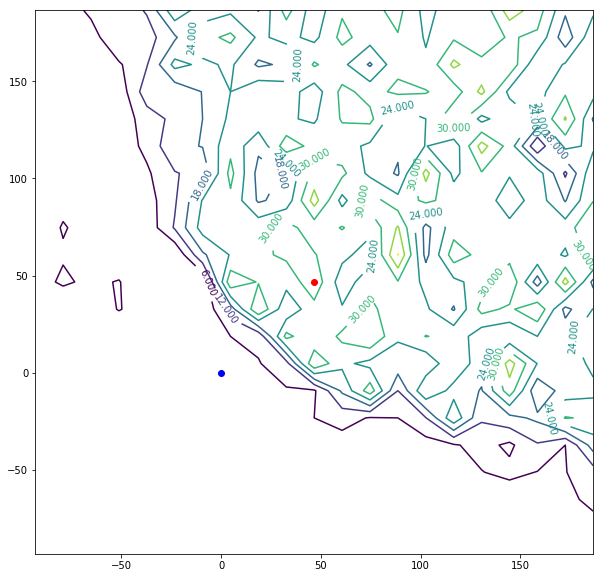

In [17]:
X,Y = np.meshgrid(gx,gy)
plt.figure(figsize=(10,10))
#cs = plt.contour(X,Y, loss_map,levels = np.linspace(0,30,16))
cs = plt.contour(X,Y, loss_map)
plt.clabel(cs, inline=1, fontsize=10)
plt.plot(0,0,'bo')
plt.plot(b1_norm,b2_norm,'ro')

plt.savefig('{}_init.png'.format(env_name))
#plt.contour(X,Y, std_map)

In [ ]:
n_train = 25
GP_X= (np.random.random(size=(n_train,2)) -0.5)*0.2
GP_Y=[]

for i, (x1,y1) in enumerate(GP_X):
    vec = origin + b1 * x1 + b2 * y1
    tnet.set_weight_vector(vec, device)
    loss = evaluate_net(tnet, env)
    GP_Y.append(loss)
    print(i, x1, y1, loss)
print()

In [ ]:
X,Y = np.meshgrid(gx,gy)
#print(X)
#print(Y)
    
fig, axes = plt.subplots(1,2, figsize=(15,10))
    

cs = axes[0].contour(X,Y,loss_map)
plt.clabel(cs, inline=1, fontsize=10)
axes[0].set_title('Loss')
cs = axes[1].contour(X,Y,std_map )
plt.clabel(cs, inline=1, fontsize=10)
axes[1].set_title('Std')
fig.suptitle('beamrider')


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, WhiteKernel, ConstantKernel, ExpSineSquared ,Matern

In [ ]:
len(GP_X)

In [ ]:
kernel = RBF(1e-5) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(GP_X, GP_Y)

In [ ]:
gp.log_marginal_likelihood()

In [ ]:
test_X

In [ ]:
test_X = np.vstack((X.flatten(), Y.flatten())).T
test_X.shape

In [ ]:
y_mean, y_cov = gp.predict(test_X, return_cov=True)

posterior_nums = 3



In [ ]:
loss_map

In [ ]:
y_mean.reshape(-1,scale)

In [ ]:
fig, axs = plt.subplots(2,figsize=(10,20))
ax = axs[0]
cs = ax.contour(X, Y, loss_map)
plt.clabel(cs, inline=1, fontsize=10)
ax = axs[1]
cs = ax.contour(X, Y, y_mean.reshape(-1,scale))
plt.clabel(cs, inline=1, fontsize=10)


plt.tight_layout()
plt.show()

In [ ]:
with open('./PongNoFrameskip-v4_11.pkl','rb') as r:
    m = pickle.load(r)

In [ ]:
X,Y = np.meshgrid(range(11), range(11))
cs = plt.contour(X,Y, m)
plt.clabel(cs, inline=1, fontsize=10)